<a href="https://colab.research.google.com/github/soohyunme/TensorFlow_Tutorial/blob/main/Code/19_Classify_cancer_beginner_project_example/train_isic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import math
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_examples = 1182
test_examples = 151
validation_examples = 168
img_height = img_width = 224
batch_size = 32

In [4]:
# NasNet
model = keras.Sequential([
        hub.KerasLayer('https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5',
                       trainable=True),
        layers.Dense(1, activation='sigmoid'),
])

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 15,
    zoom_range = (0.95, 0.95),
    horizontal_flip = True,
    vertical_flip = True,
    data_format = 'channels_last',
    dtype = tf.float32,
)

validation_datagen = ImageDataGenerator(rescale=1.0/255, dtype=tf.float32)
test_datagen = ImageDataGenerator(rescale=1.0/255, dtype=tf.float32)

In [6]:
train_gen = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    seed=123
)

test_gen = test_datagen.flow_from_directory(
    'data/test/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    seed=123
)

validation_gen = validation_datagen.flow_from_directory(
    'data/validation/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    seed=123
)

Found 1182 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
Found 167 images belonging to 2 classes.


In [7]:
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

In [8]:
model.compile(
    optimizer = keras.optimizers.Adam(lr=3e-4),
    loss=[keras.losses.BinaryCrossentropy(from_logits=False)],
    metrics=METRICS
)

model.fit(
    train_gen,
    verbose=2,
    epochs=1,
    steps_per_epoch=train_examples // batch_size,
    validation_data=validation_gen,
    validation_steps=validation_examples // batch_size,
    callbacks=[keras.callbacks.ModelCheckpoint('isic_model')]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


INFO:tensorflow:Assets written to: isic_model/assets


INFO:tensorflow:Assets written to: isic_model/assets


36/36 - 107s - loss: 0.8171 - accuracy: 0.8087 - precision: 0.4771 - recall: 0.2419 - auc: 0.7561 - val_loss: 0.7847 - val_accuracy: 0.8625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6779 - 107s/epoch - 3s/step


In [9]:
def plot_roc(labels, data):
    predictions = model.predict(data)
    fp, tp, _= roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.show()


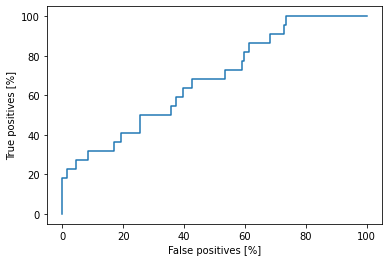

6/6 - 3s - loss: 0.7707 - accuracy: 0.8683 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6851 - 3s/epoch - 455ms/step
5/5 - 2s - loss: 0.7830 - accuracy: 0.8543 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6815 - 2s/epoch - 443ms/step


[0.7829766869544983, 0.8543046116828918, 0.0, 0.0, 0.6814658045768738]

In [10]:
test_labels = np.array([])
num_batches = 0

for _, y in test_gen:
    test_labels = np.append(test_labels, y)
    num_batches += 1
    if num_batches == math.ceil(test_examples / batch_size):
        break
plot_roc(test_labels, test_gen)

model.evaluate(validation_gen, verbose=2)
model.evaluate(test_gen, verbose=2)